##   Facial Expression Recognition Using Transfer Learning Version 2: ResNet50 Model

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


### Task 1: Import Libraries

In [1]:

from glob import glob
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.utils import np_utils
import scikitplot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Dropout, Dense, Flatten,GlobalMaxPool2D,GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import ResNet50
from keras.layers import Input
from keras.utils import plot_model
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.models import model_from_json

### Task 2: Explore the datasets and Plot Sample Images

In [2]:
os.listdir("./train/")

['happy', 'sad', 'fear', 'surprise', 'neutral', 'angry', 'disgust']

In [34]:
INPUT_PATH = "./train/"
total_images = 0
for dir in os.listdir(INPUT_PATH):
    count = len(os.listdir(INPUT_PATH + dir))
    total_images += count
    print(f"{dir} has {count} images")

print(f"total_images : {total_images}")

happy has 7214 images
sad has 4830 images
fear has 4097 images
surprise has 3171 images
neutral has 4965 images
angry has 3995 images
disgust has 436 images
total_images : 28708
time: 1.45 s


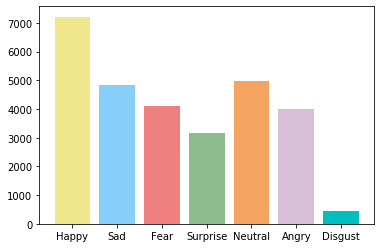

time: 187 ms


In [28]:
# Set the colors
#colors = ['b', 'g', 'r', 'c', 'm', 'y', 'g']
colors = ['khaki','lightskyblue', 'lightcoral', 'darkseagreen', 'sandybrown', 'thistle', 'c']
images = [7214, 4830, 4097, 3171, 4965,3995,436]
bars = ('Happy', 'Sad', 'Fear', 'Surprise', 'Neutral','Angry','Disgust')
y_pos = np.arange(len(bars))
 
# Create bars
plt.bar(y_pos, images,color=colors)
 
# Create names on the x-axis
plt.xticks(y_pos, bars)
 
# Show graphic
plt.show()


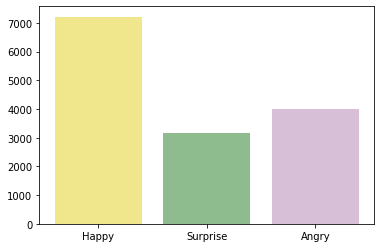

time: 322 ms


In [29]:
# Set the colors
#colors = ['b', 'g', 'r', 'c', 'm', 'y', 'g']
colors = ['khaki','darkseagreen', 'thistle']
images = [7214, 3171,3995]
bars = ('Happy', 'Surprise', 'Angry')
y_pos = np.arange(len(bars))
 
# Create bars
plt.bar(y_pos, images,color=colors)
 
# Create names on the x-axis
plt.xticks(y_pos, bars)
 
# Show graphic
plt.show()

In [35]:
import autoreload
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 1.33 ms


In [36]:
total_images

28708

time: 3.58 ms


### Choosing Three emotions for our Analysis

In [37]:
#TOP_EMOTIONS = ['fear', 'angry', 'happy', 'neutral', 'disgust', 'surprise', 'sad']
TOP_EMOTIONS = ['angry', 'happy', 'surprise']
total_images -= 14328
total_images
img_arr = np.empty(shape=(total_images,48,48,3))
img_label = np.empty(shape=(total_images))
label_to_text = {}

i = 0
e = 0
for dir_ in os.listdir(INPUT_PATH):
    if dir_ in TOP_EMOTIONS:
        label_to_text[e] = dir_
        for f in os.listdir(INPUT_PATH + dir_ + "/"):
            img_arr[i] = cv2.imread(INPUT_PATH + dir_ + "/" + f)
            img_label[i] = e
            i += 1
        print(f"loaded all {dir_} images to numpy arrays")
        e += 1

img_arr.shape, img_label



loaded all happy images to numpy arrays
loaded all surprise images to numpy arrays
loaded all angry images to numpy arrays


((14380, 48, 48, 3), array([0., 0., 0., ..., 2., 2., 2.]))

time: 3min 51s


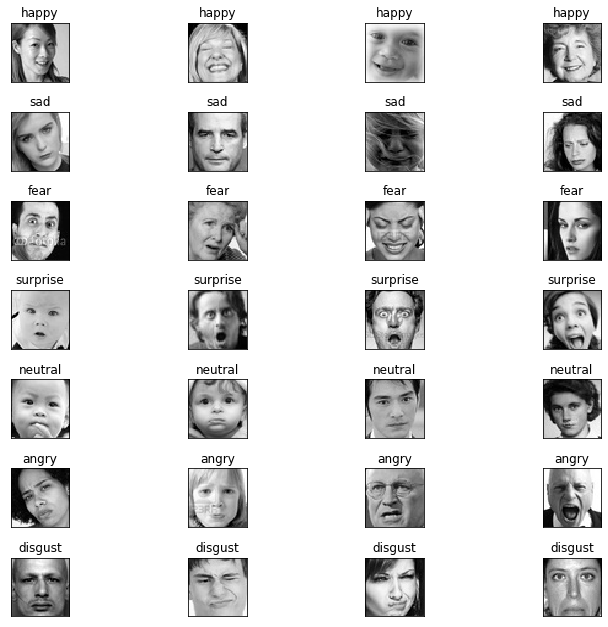

time: 4.61 s


In [64]:
fig = plt.figure(1, (10,10))

idx = 0
for k in label_to_text:
    sample_indices = np.random.choice(np.where(img_label==k)[0], size=4, replace=False)
    sample_images = img_arr[sample_indices]
    for img in sample_images:
        idx += 1
        ax = plt.subplot(8,4,idx)
        ax.imshow(img[:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[k])
        plt.tight_layout()

### Task 3: Generate Training and Validation Batches

In [38]:
img_arr.shape

(14380, 48, 48, 3)

time: 3.17 ms


In [39]:
img_label = np_utils.to_categorical(img_label)
img_label.shape

(14380, 3)

time: 7.19 ms


In [40]:
img_arr = img_arr / 255.

X_train, X_test, y_train, y_test = train_test_split(img_arr, img_label,
                                                    shuffle=True, stratify=img_label,
                                                    test_size=0.1, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12942, 48, 48, 3), (1438, 48, 48, 3), (12942, 3), (1438, 3))

time: 2 s


In [41]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]



time: 1.27 ms


### Task 4: Create RestNet50 Model

In [52]:
model= ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(img_width, img_height, img_depth)))

model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 54, 54, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 24, 24, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 24, 24, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [53]:

x = model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x) 
predictions = Dense(3, activation='softmax')(x)
model = Model(model.input, predictions)

time: 62.9 ms


In [44]:
model.layers

time: 12.2 ms


In [54]:
for layer in model.layers[:38]:
    layer.trainable = False

time: 3.34 ms


#### Image Preprocessing & Data Augmention

In [55]:
trainAug = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

valAug = ImageDataGenerator()

time: 1.55 ms


In [56]:
trainAug.fit(X_train)

time: 1.14 s


In [57]:
"""
I used two callbacks one is `early stopping` for avoiding overfitting training data
and other `ReduceLROnPlateau` for learning rate.
"""
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00008,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.0001,
    factor=0.25,
    patience=4,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]


time: 1.69 ms


In [58]:
batch_size = 50
epochs = 40
opt = Adam(lr=0.001)

time: 969 µs


In [59]:
print(np.count_nonzero(np.isnan(X_train)))
print(np.any(np.isnan(y_train)))

0
False
time: 136 ms


In [28]:
from tensorflow.keras import optimizers


time: 631 µs


### Task 5: Train and Evaluate Model

In [60]:
model.compile(
        loss='categorical_crossentropy',
        optimizer=opt,
        metrics=['accuracy']
)

history = model.fit_generator(
    trainAug.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)
    
model_json = model.to_json()
with open("./model_ResNet.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("./model_ResNet.h5")
print("Saved model to disk")



Epoch 1/40
259/258 [==============================] - 1316s 5s/step - loss: 1.0098 - accuracy: 0.5226 - val_loss: 1.2152 - val_accuracy: 0.5028 - lr: 0.0010
Epoch 2/40
259/258 [==============================] - 1279s 5s/step - loss: 0.9373 - accuracy: 0.5617 - val_loss: 2.3100 - val_accuracy: 0.2204 - lr: 0.0010
Epoch 3/40
259/258 [==============================] - 1278s 5s/step - loss: 0.9199 - accuracy: 0.5657 - val_loss: 1.0649 - val_accuracy: 0.5146 - lr: 0.0010
Epoch 4/40
259/258 [==============================] - 1347s 5s/step - loss: 0.8880 - accuracy: 0.5832 - val_loss: 0.8713 - val_accuracy: 0.5786 - lr: 0.0010
Epoch 5/40
259/258 [==============================] - 1336s 5s/step - loss: 0.8584 - accuracy: 0.6011 - val_loss: 0.9066 - val_accuracy: 0.6029 - lr: 0.0010
Epoch 6/40
259/258 [==============================] - 1274s 5s/step - loss: 0.8189 - accuracy: 0.6225 - val_loss: 1.3722 - val_accuracy: 0.4388 - lr: 0.0010
Epoch 7/40
259/258 [==============================] - 1336

259/258 [==============================] - 1159s 4s/step - loss: 0.6274 - accuracy: 0.7371 - val_loss: 0.8739 - val_accuracy: 0.7045 - lr: 0.0010
Epoch 16/40
259/258 [==============================] - 1162s 4s/step - loss: 0.6183 - accuracy: 0.7398 - val_loss: 0.5583 - val_accuracy: 0.7684 - lr: 0.0010
Epoch 17/40
259/258 [==============================] - 1166s 5s/step - loss: 0.6076 - accuracy: 0.7438 - val_loss: 0.5495 - val_accuracy: 0.7684 - lr: 0.0010
Epoch 18/40
259/258 [==============================] - ETA: 0s - loss: 0.5812 - accuracy: 0.7571
Epoch 00018: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
259/258 [==============================] - 1167s 5s/step - loss: 0.5812 - accuracy: 0.7571 - val_loss: 1.1475 - val_accuracy: 0.5772 - lr: 0.0010
Epoch 19/40
259/258 [==============================] - 1164s 4s/step - loss: 0.5440 - accuracy: 0.7762 - val_loss: 0.4535 - val_accuracy: 0.8282 - lr: 2.5000e-04
Epoch 20/40
259/258 [==============================] 

Epoch 29/40
259/258 [==============================] - 1238s 5s/step - loss: 0.4610 - accuracy: 0.8139 - val_loss: 0.3913 - val_accuracy: 0.8540 - lr: 6.2500e-05
Epoch 30/40
259/258 [==============================] - 1257s 5s/step - loss: 0.4456 - accuracy: 0.8221 - val_loss: 0.3864 - val_accuracy: 0.8567 - lr: 6.2500e-05
Epoch 31/40
259/258 [==============================] - 1446s 6s/step - loss: 0.4410 - accuracy: 0.8238 - val_loss: 0.3857 - val_accuracy: 0.8567 - lr: 6.2500e-05
Epoch 32/40
259/258 [==============================] - 1261s 5s/step - loss: 0.4365 - accuracy: 0.8266 - val_loss: 0.3784 - val_accuracy: 0.8609 - lr: 6.2500e-05
Epoch 33/40
259/258 [==============================] - 1241s 5s/step - loss: 0.4390 - accuracy: 0.8234 - val_loss: 0.3781 - val_accuracy: 0.8588 - lr: 6.2500e-05
Epoch 34/40
259/258 [==============================] - 1352s 5s/step - loss: 0.4316 - accuracy: 0.8301 - val_loss: 0.3790 - val_accuracy: 0.8630 - lr: 6.2500e-05
Epoch 35/40
259/258 [=======

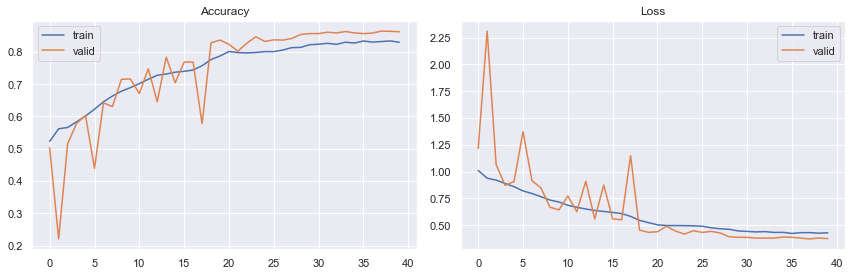

time: 1.23 s


In [61]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

#plt.savefig('epoch_history_resnet7-3-split.png')
plt.show()

In [62]:
import itertools
from sklearn.metrics import classification_report

time: 1.03 ms


test accuracy: 86.2309 %


              precision    recall  f1-score   support

           0       0.91      0.91      0.91       721
           1       0.83      0.79      0.81       317
           2       0.80      0.83      0.82       400

    accuracy                           0.86      1438
   macro avg       0.85      0.84      0.85      1438
weighted avg       0.86      0.86      0.86      1438



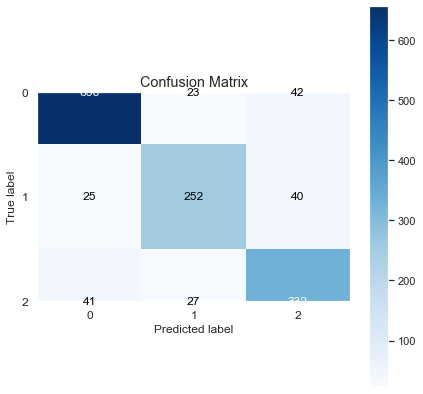

time: 18.7 s


In [63]:
yhat_test = np.argmax(model.predict(X_test), axis=1)
ytest_ = np.argmax(y_test, axis=1)
scikitplot.metrics.plot_confusion_matrix(ytest_, yhat_test, figsize=(7,7))
#pyplot.savefig("confusion_matrix_mobilenet.png")

test_accu = np.sum(ytest_ == yhat_test) / len(ytest_) * 100
print(f"test accuracy: {round(test_accu, 4)} %\n\n")

print(classification_report(ytest_, yhat_test))

In [74]:

def print_confusionMatrix(Y_TestLabels, PredictedLabels):
    confusionMatx = confusion_matrix(Y_TestLabels, PredictedLabels)
    
    precision = confusionMatx/confusionMatx.sum(axis = 0)
    
    recall = (confusionMatx.T/confusionMatx.sum(axis = 1)).T
    
    sns.set(font_scale=1.5)`
    
    # confusionMatx = [[1, 2],
    #                  [3, 4]]
    # confusionMatx.T = [[1, 3],
    #                   [2, 4]]
    # confusionMatx.sum(axis = 1)  axis=0 corresponds to columns and axis=1 corresponds to rows in two diamensional array
    # confusionMatx.sum(axix =1) = [[3, 7]]
    # (confusionMatx.T)/(confusionMatx.sum(axis=1)) = [[1/3, 3/7]
    #                                                  [2/3, 4/7]]

    # (confusionMatx.T)/(confusionMatx.sum(axis=1)).T = [[1/3, 2/3]
    #                                                    [3/7, 4/7]]
    # sum of row elements = 1
    
    labels = ["HAPPY","SURPRISE","ANGRY"]
    
    plt.figure(figsize=(8,8))
    sns.heatmap(confusionMatx, cmap = "Blues", annot = True, fmt = ".1f", xticklabels=labels, yticklabels=labels)
    plt.title("Confusion Matrix", fontsize = 30)
    plt.xlabel('Predicted Class', fontsize = 20)
    plt.ylabel('Original Class', fontsize = 20)
    plt.tick_params(labelsize = 15)
    plt.xticks(rotation = 90)
    plt.show()
    
    print("-"*125)
    
    plt.figure(figsize=(8,8))
    sns.heatmap(precision, cmap = "Blues", annot = True, fmt = ".2f", xticklabels=labels, yticklabels=labels)
    plt.title("Precision Matrix", fontsize = 30)
    plt.xlabel('Predicted Class', fontsize = 20)
    plt.ylabel('Original Class', fontsize = 20)
    plt.tick_params(labelsize = 15)
    plt.xticks(rotation = 90)
    plt.show()
    
    print("-"*125)
    
    plt.figure(figsize=(8,8))
    sns.heatmap(recall, cmap = "Blues", annot = True, fmt = ".2f", xticklabels=labels, yticklabels=labels)
    plt.title("Recall Matrix", fontsize = 30)
    plt.xlabel('Predicted Class', fontsize = 20)
    plt.ylabel('Original Class', fontsize = 20)
    plt.tick_params(labelsize = 15)
    plt.xticks(rotation = 90)
    plt.show()

time: 6.76 ms


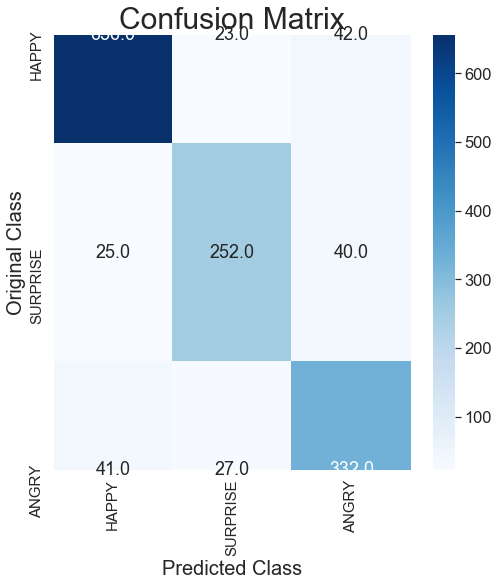

-----------------------------------------------------------------------------------------------------------------------------


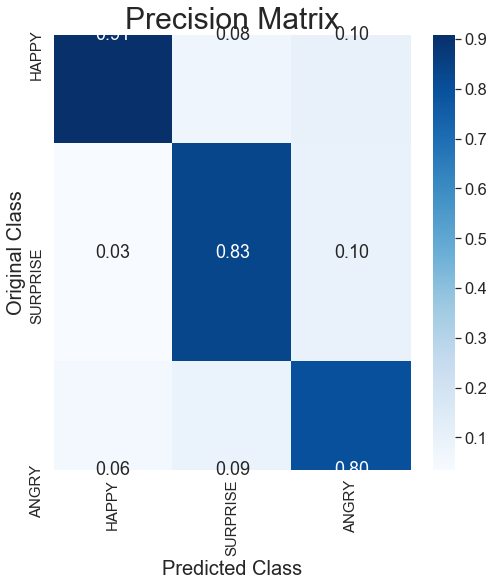

-----------------------------------------------------------------------------------------------------------------------------


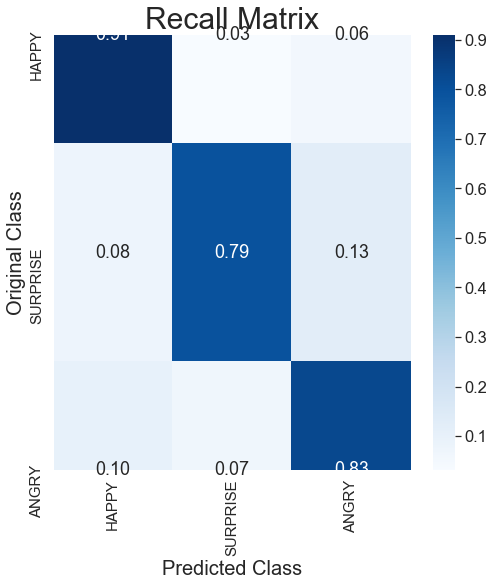

time: 993 ms


In [75]:
print_confusionMatrix(ytest_, yhat_test)


In [64]:
from sklearn.metrics import confusion_matrix

time: 678 µs


[[656  23  42]
 [ 25 252  40]
 [ 41  27 332]]


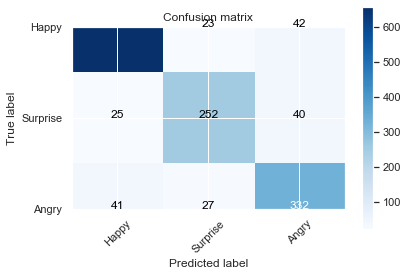

time: 332 ms


In [66]:
cm = confusion_matrix(ytest_, yhat_test)

labels = ['Happy','Surprise', 'Angry' ]
title='Confusion matrix'
print(cm)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [76]:
text_to_label = dict((v,k) for k,v in label_to_text.items())
text_to_label

{'happy': 0, 'surprise': 1, 'angry': 2}

time: 4.06 ms


In [77]:
import math

time: 744 µs


### Task 7: Identify the misclassified Images

In [78]:
def plot_miss_classified(emotion):
    miss_happy_indices = np.where((ytest_ != yhat_test) & (ytest_==text_to_label[emotion]))[0]
    print(f"total {len(miss_happy_indices)} miss labels out of {len(np.where(ytest_==text_to_label[emotion])[0])} for emotion {emotion}")

    cols = 15
    rows = math.ceil(len(miss_happy_indices) / cols)
    fig = plt.figure(1, (20, rows * 2))

    for i,idx in enumerate(miss_happy_indices):
        sample_img = X_test[idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        pred = label_to_text[np.argmax(model.predict(sample_img), axis=1)[0]]

        ax = plt.subplot(rows,cols,i+1)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"p:{pred}")    

time: 3.5 ms


total 65 miss labels out of 721 for emotion happy


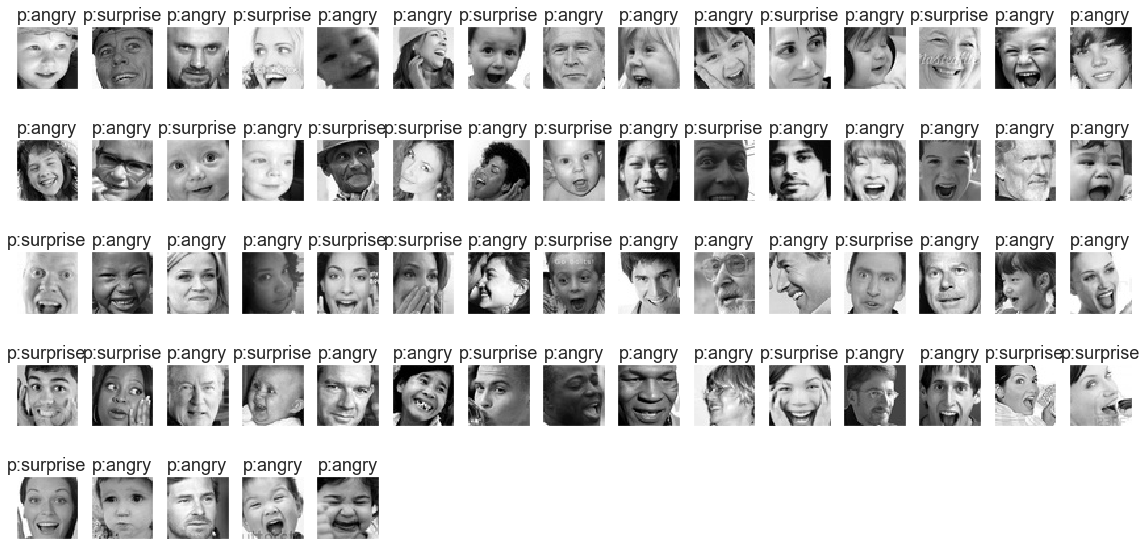

time: 7.52 s


In [79]:
plot_miss_classified(emotion="happy")

total 65 miss labels out of 317 for emotion surprise


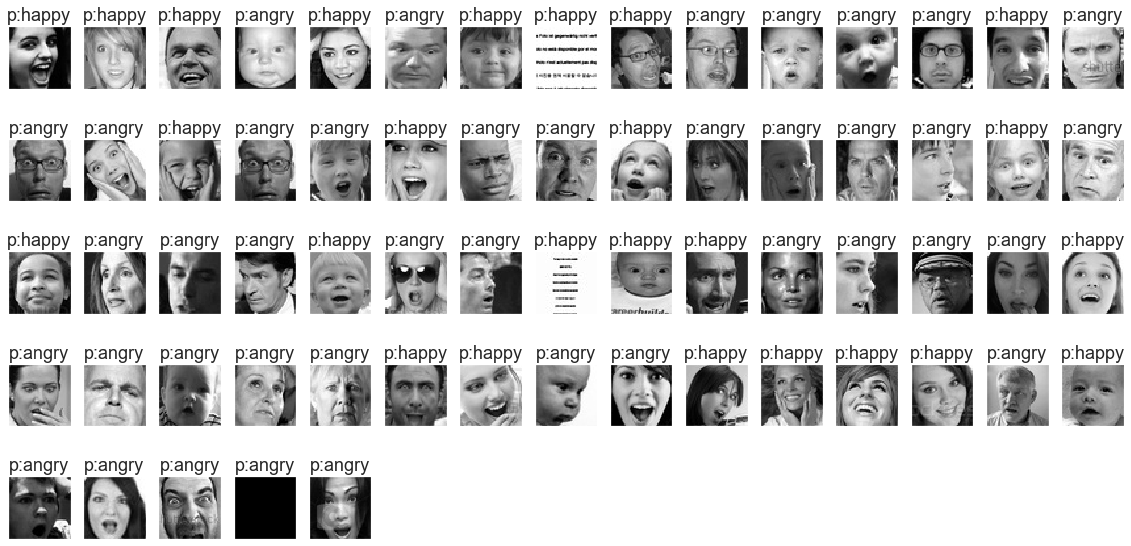

time: 8.13 s


In [80]:
plot_miss_classified(emotion="surprise")

total 68 miss labels out of 400 for emotion angry


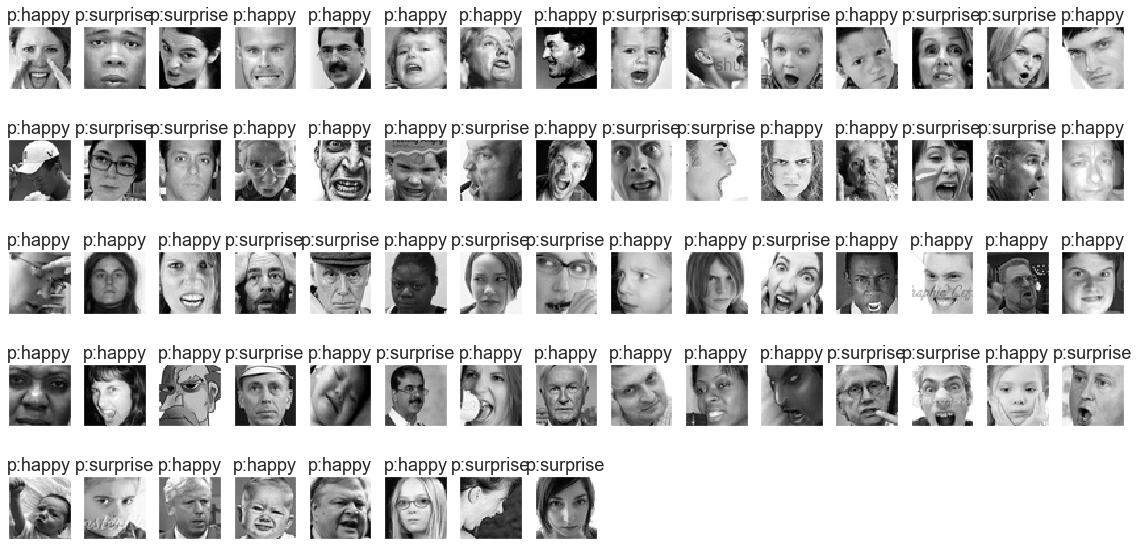

time: 8.27 s


In [81]:
plot_miss_classified(emotion="angry")